# Data Cleaning
Sep 14 2020: Created

In [1]:
# import libraries
import os
import shutil
import pandas as pd
import numpy as np

In [2]:
# set directories
os.chdir("../") # change current working directory to root directory of project
brazil_amld_raw = "./data/raw/brazil_amld"
brazil_amld_interim = "./data/interim/brazil_amld"

## Reorganize Directory

In [3]:
# extract info from raw directories and file name into dictionary
brazil_amld_dict = {}
file_count = 0
image_count = 0

# dict keys
dir_key = ["cam_trap", "species", "num_animal"]
metadata_key = ["year", "month", "day", "hour", "minute", "second"]
key_list = ["file_path", "file_name", "file_type", "data_type",
            "image_id", "num_animal_new", "file_path_new", "file_name_new"]

for root, dirs, files in os.walk(brazil_amld_raw):
    for name in files:
        if not name.endswith((".DS_Store")):
            file_id = f"{file_count:04d}"
            file_type = name.split(".")[1].lower()
            
            # initialise dict
            brazil_amld_dict[file_id] = dict(zip(dir_key, root.split("/")[4:]))
            species = brazil_amld_dict[file_id]["species"]
            cam_trap = brazil_amld_dict[file_id]["cam_trap"]
            # num_animal_new
            num_animal_new = brazil_amld_dict[file_id].get("num_animal", "01")
            
            # data_type and etc
            if file_type == "jpg":
                data_type = "image"
                image_id = f"{image_count:04d}"
                metadata = name.split(".")[0].split(" ")
                # file_name_new
                file_name_new = "_".join((image_id, cam_trap, species, num_animal_new) \
                                         + tuple(metadata)) + "." + file_type
                image_count += 1
            else: 
                if file_type == "mp4":
                    data_type = "video"
                else:
                    data_type = "bbox"
                image_id = ""
                metadata = [""]*6
                file_name_new = name
            
            # file_path_new
            file_path_new = "/".join((brazil_amld_interim, data_type, species))
            
            # update dict
            value_list = [root, name, file_type, data_type, image_id, num_animal_new,  file_path_new, file_name_new]
            brazil_amld_dict[file_id].update(dict(zip(metadata_key, metadata)))
            brazil_amld_dict[file_id].update(dict(zip(key_list, value_list)))
            file_count += 1

In [14]:
# copy all data from raw data directory to interim data directory with renamed file name
for k, v in brazil_amld_dict.items():
    os.makedirs(v['file_path_new'], exist_ok=True)
    shutil.copyfile(v['file_path'] + '/' + v['file_name'], v['file_path_new'] + "/" + v['file_name_new'])

## Extract Directory & File Info into csv

In [4]:
# tabulate dictionary into dataframe
df_brazil_amld = pd.DataFrame(columns = ["file_id"] + list(brazil_amld_dict["0000"].keys()))
for k, v in brazil_amld_dict.items():
    brazil_amld_dict[k].update({"file_id":k})
    df_brazil_amld = df_brazil_amld.append(brazil_amld_dict[k], ignore_index=True)

In [5]:
# mapping of species to binary label
species_na_list = ["Human", "team", "Unknown"]
df_brazil_amld["species_binary"] = np.where(df_brazil_amld.species=="Ghost", "Ghost",
                                            np.where(df_brazil_amld.species.isin(species_na_list),
                                                     "Exclude", "Animal"))

In [6]:
# dictionary of species to species subcategories
species_category = {
    'Rodents':('Guerlinguetus', 'CuniculusPaca', 'Rodent'),
    'Opossums':('MarmosopsIncanus', 'MetachirusMyosurus', 'DidelphisAurita', 'CaluromysPhilander'), 
    'Ghost':('Ghost',),
    'Felines':('LeopardusWiedii', 'LeopardusPardalis'),
    'Birds':('Bird', 'PenelopeSuperciliaris', 'LeptotilaRufaxilla'),
    'SmallMammals':('CabassousTatouay', 'TamanduaTetradactyla', 'EuphractusSexcinctus', 
                 'ProcyonCancrivorus', 'DasypusNovemcinctus', 'NasuaNasua', 'EiraBarbara'), 
    'Reptiles':('SalvatorMerianae',),
    'Canines':('CerdocyonThous', 'CanisLupusFamiliaris'), 
    'Exclude':('Unknown', 'Human', 'team', 'NonIdent')}

In [7]:
# helper function to get key from value in dictionary
def get_key(value, dictionary):
    for k, v in dictionary.items():
        if value in v:
            return k

In [8]:
# mapping of species to species subcategories
df_brazil_amld['species_category'] = list(map(lambda x: get_key(x, species_category), df_brazil_amld.species))

In [9]:
df_brazil_amld

,file_id,cam_trap,species,num_animal,year,month,day,hour,minute,second,file_path,file_name,file_type,data_type,image_id,num_animal_new,file_path_new,file_name_new,species_binary,species_category
0,0000,SSAMLD2_2,Guerlinguetus,01,2019,04,11,08,48,26,./data/raw/brazil_amld/SSAMLD2_2/Guerlinguetus/01,2019 04 11 08 48 26.JPG,jpg,image,0000,01,./data/interim/brazil_amld/image/Guerlinguetus,0000_SSAMLD2_2_Guerlinguetus_01_2019_04_11_08_...,Animal,Rodents
1,0001,SSAMLD2_2,Guerlinguetus,01,,,,,,,./data/raw/brazil_amld/SSAMLD2_2/Guerlinguetus/01,labels_ssamld2_2_guerlinguetus_01_202008300354...,zip,bbox,,01,./data/interim/brazil_amld/bbox/Guerlinguetus,labels_ssamld2_2_guerlinguetus_01_202008300354...,Animal,Rodents
2,0002,SSAMLD2_2,Guerlinguetus,01,2019,04,11,08,48,24,./data/raw/brazil_amld/SSAMLD2_2/Guerlinguetus/01,2019 04 11 08 48 24.JPG,jpg,image,0001,01,./data/interim/brazil_amld/image/Guerlinguetus,0001_SSAMLD2_2_Guerlinguetus_01_2019_04_11_08_...,Animal,Rodents
3,0003,SSAMLD2_2,Guerlinguetus,01,2019,04,11,08,48,20,./data/raw/brazil_amld/SSAMLD2_2/Guerlinguetus/01,2019 04 11 08 48 20.JPG,jpg,image,0002,01,./data/interim/brazil_amld/image/Guerlinguetus,0002_SSAMLD2_2_Guerlinguetus_01_2019_04_11_08_...,Animal,Rodents
4,0004,SSAMLD2_2,Guerlinguetus,01,2019,04,11,08,48,22,./data/raw/brazil_amld/SSAMLD2_2/Guerlinguetus/01,2019 04 11 08 48 22.JPG,jpg,image,0003,01,./data/interim/brazil_amld/image/Guerlinguetus,0003_SSAMLD2_2_Guerlinguetus_01_2019_04_11_08_...,Animal,Rodents
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,1989,CT03,Human,01,2018,08,15,09,51,31,./data/raw/brazil_amld/CT03/Human/01,2018 08 15 09 51 31.JPG,jpg,image,1453,01,./data/interim/brazil_amld/image/Human,1453_CT03_Human_01_2018_08_15_09_51_31.jpg,Exclude,Exclude
1990,1990,CT03,Human,01,2018,08,21,11,05,08,./data/raw/brazil_amld/CT03/Human/01,2018 08 21 11 05 08.JPG,jpg,image,1454,01,./data/interim/brazil_amld/image/Human,1454_CT03_Human_01_2018_08_21_11_05_08.jpg,Exclude,Exclude
1991,1991,CT03,Human,01,,,,,,,./data/raw/brazil_amld/CT03/Human/01,labels_ct03_human_01_20200908112322.csv,csv,bbox,,01,./data/interim/brazil_amld/bbox/Human,labels_ct03_human_01_20200908112322.csv,Exclude,Exclude
1992,1992,CT03,Human,01,2018,08,09,10,14,20,./data/raw/brazil_amld/CT03/Human/01,2018 08 09 10 14 20.JPG,jpg,image,1455,01,./data/interim/brazil_amld/image/Human,1455_CT03_Human_01_2018_08_09_10_14_20.jpg,Exclude,Exclude


In [10]:
# export df to csv
df_brazil_amld.to_csv(brazil_amld_interim + "/brazil_amld.csv", index=False)

## EDA Visualisations

In [11]:
# df for only images
df_brazil_amld_image = df_brazil_amld[df_brazil_amld.data_type == "image"]

In [12]:
df_brazil_amld_image

,file_id,cam_trap,species,num_animal,year,month,day,hour,minute,second,file_path,file_name,file_type,data_type,image_id,num_animal_new,file_path_new,file_name_new,species_binary,species_category
0,0000,SSAMLD2_2,Guerlinguetus,01,2019,04,11,08,48,26,./data/raw/brazil_amld/SSAMLD2_2/Guerlinguetus/01,2019 04 11 08 48 26.JPG,jpg,image,0000,01,./data/interim/brazil_amld/image/Guerlinguetus,0000_SSAMLD2_2_Guerlinguetus_01_2019_04_11_08_...,Animal,Rodents
2,0002,SSAMLD2_2,Guerlinguetus,01,2019,04,11,08,48,24,./data/raw/brazil_amld/SSAMLD2_2/Guerlinguetus/01,2019 04 11 08 48 24.JPG,jpg,image,0001,01,./data/interim/brazil_amld/image/Guerlinguetus,0001_SSAMLD2_2_Guerlinguetus_01_2019_04_11_08_...,Animal,Rodents
3,0003,SSAMLD2_2,Guerlinguetus,01,2019,04,11,08,48,20,./data/raw/brazil_amld/SSAMLD2_2/Guerlinguetus/01,2019 04 11 08 48 20.JPG,jpg,image,0002,01,./data/interim/brazil_amld/image/Guerlinguetus,0002_SSAMLD2_2_Guerlinguetus_01_2019_04_11_08_...,Animal,Rodents
4,0004,SSAMLD2_2,Guerlinguetus,01,2019,04,11,08,48,22,./data/raw/brazil_amld/SSAMLD2_2/Guerlinguetus/01,2019 04 11 08 48 22.JPG,jpg,image,0003,01,./data/interim/brazil_amld/image/Guerlinguetus,0003_SSAMLD2_2_Guerlinguetus_01_2019_04_11_08_...,Animal,Rodents
6,0006,SSAMLD2_2,Guerlinguetus,01,2019,03,27,07,26,16,./data/raw/brazil_amld/SSAMLD2_2/Guerlinguetus/01,2019 03 27 07 26 16.JPG,jpg,image,0004,01,./data/interim/brazil_amld/image/Guerlinguetus,0004_SSAMLD2_2_Guerlinguetus_01_2019_03_27_07_...,Animal,Rodents
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1976,1976,CT03,CerdocyonThous,01,2018,08,13,18,59,54,./data/raw/brazil_amld/CT03/CerdocyonThous/01,2018 08 13 18 59 54.JPG,jpg,image,1451,01,./data/interim/brazil_amld/image/CerdocyonThous,1451_CT03_CerdocyonThous_01_2018_08_13_18_59_5...,Animal,Canines
1981,1981,CT03,Human,02,2018,08,21,11,03,46,./data/raw/brazil_amld/CT03/Human/02,2018 08 21 11 03 46.JPG,jpg,image,1452,02,./data/interim/brazil_amld/image/Human,1452_CT03_Human_02_2018_08_21_11_03_46.jpg,Exclude,Exclude
1989,1989,CT03,Human,01,2018,08,15,09,51,31,./data/raw/brazil_amld/CT03/Human/01,2018 08 15 09 51 31.JPG,jpg,image,1453,01,./data/interim/brazil_amld/image/Human,1453_CT03_Human_01_2018_08_15_09_51_31.jpg,Exclude,Exclude
1990,1990,CT03,Human,01,2018,08,21,11,05,08,./data/raw/brazil_amld/CT03/Human/01,2018 08 21 11 05 08.JPG,jpg,image,1454,01,./data/interim/brazil_amld/image/Human,1454_CT03_Human_01_2018_08_21_11_05_08.jpg,Exclude,Exclude


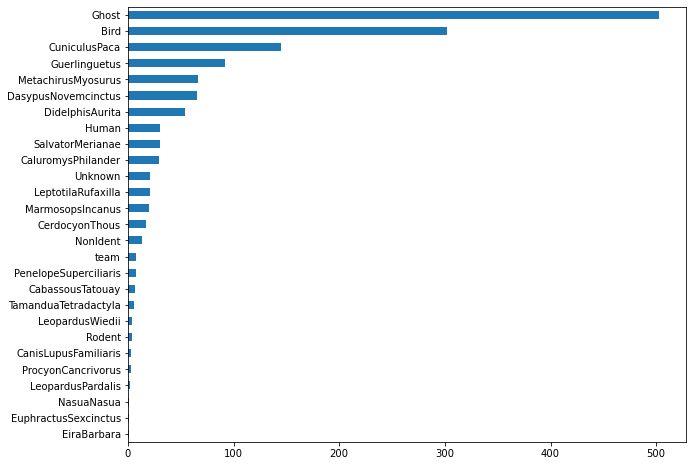

In [13]:
# count of images per species
df_brazil_amld_image.species.value_counts()[::-1].plot.barh(figsize=(10, 8));

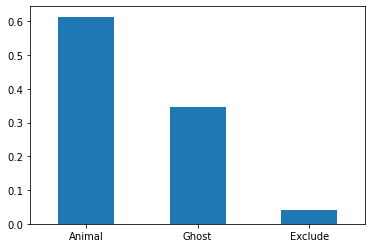

In [16]:
# % of images per binary label
(df_brazil_amld_image.species_binary.value_counts()/df_brazil_amld_image.species_binary.count()).plot.bar(rot=0);